In [1]:
# Author: Arthur Prigent
# Email: aprigent@geomar.de

#### DATA ####
# https://downloads.psl.noaa.gov/Datasets/
from functions import *
import warnings
warnings.filterwarnings("ignore")

# Maps

# [Last month Tropical Atlantic ocean OI-SST V2 SST anomalies ](./make_map_tropical_atlantic.html)
# [Last month Tropical Pacific ocean OI-SST V2 SST anomalies ](./make_map_tropical_pacific.html)
# [Last month Tropical Indian ocean OI-SST V2 SST anomalies ](./make_map_tropical_indian.html)

# WAMOI

## [West African Monsoon Onset](#test)

# AMM
## [Atlantic Meridional mode index](#test2)

# SSTa timeseries

## Monthly data
## - [Monthly timeseries](#monthly)

## Weekly data 
## - [Weekly ABA timeseries](#ABA_weekly)
## - [Weekly ATL3 timeseries](#ATL3_weekly)
## - [Weekly NINO3.4 timeseries](#NINO34_weekly)
## - [Weekly DNI timeseries](#DNI_weekly)
## - [Weekly NNI timeseries](#NNI_weekly)
## - [Weekly CNI timeseries](#CNI_weekly)

# Regions of interests

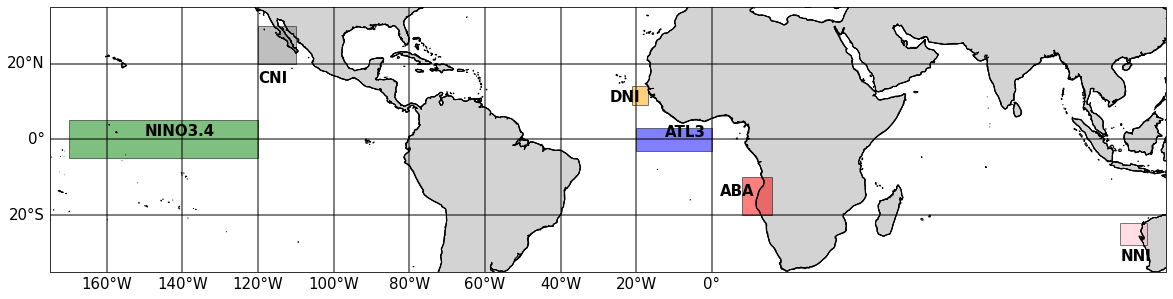

In [2]:
plot_regions_of_interest()

# Last update 

In [3]:
print(str(now)[:16])

2021-07-09 11:21


# Read SST data 

In [4]:
path_oi_wk = 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2/'
(ssta_atl3_norm_oi_wk,ssta_aba_norm_oi_wk,
 ssta_nino34_norm_oi_wk,ssta_dni_norm_oi_wk,
 ssta_cni_norm_oi_wk,ssta_nni_norm_oi_wk) = read_data_compute_anomalies_week(path_oi_wk)

In [5]:
path_data = 'https://psl.noaa.gov/thredds/dodsC/Datasets/COBE/sst.mon.mean.nc'
(ssta_atl3_norm_cobe,ssta_aba_norm_cobe,
 ssta_nino34_norm_cobe,ssta_dni_norm_cobe,
 ssta_cni_norm_cobe,ssta_nni_norm_cobe) = read_data_compute_anomalies(path_data)

In [6]:
path_oi = 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2/'
(ssta_atl3_norm_oi,ssta_aba_norm_oi,
 ssta_nino34_norm_oi,ssta_dni_norm_oi,
 ssta_cni_norm_oi,ssta_nni_norm_oi) = read_data_compute_anomalies_oi(path_oi)

In [7]:
path_ersstv5 = 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc'
(ssta_atl3_norm_ersst,ssta_aba_norm_ersst,
 ssta_nino34_norm_ersst,ssta_dni_norm_ersst,
 ssta_cni_norm_ersst,ssta_nni_norm_ersst) = read_data_compute_anomalies_ersstv5(path_ersstv5)

# Timeseries of SST anomalies

# Monthly data <a id='monthly'></a>


# [COBE SST](https://psl.noaa.gov/data/gridded/data.cobe.html) | 1$^{\circ}$ x 1$^{\circ}$ | Monthly

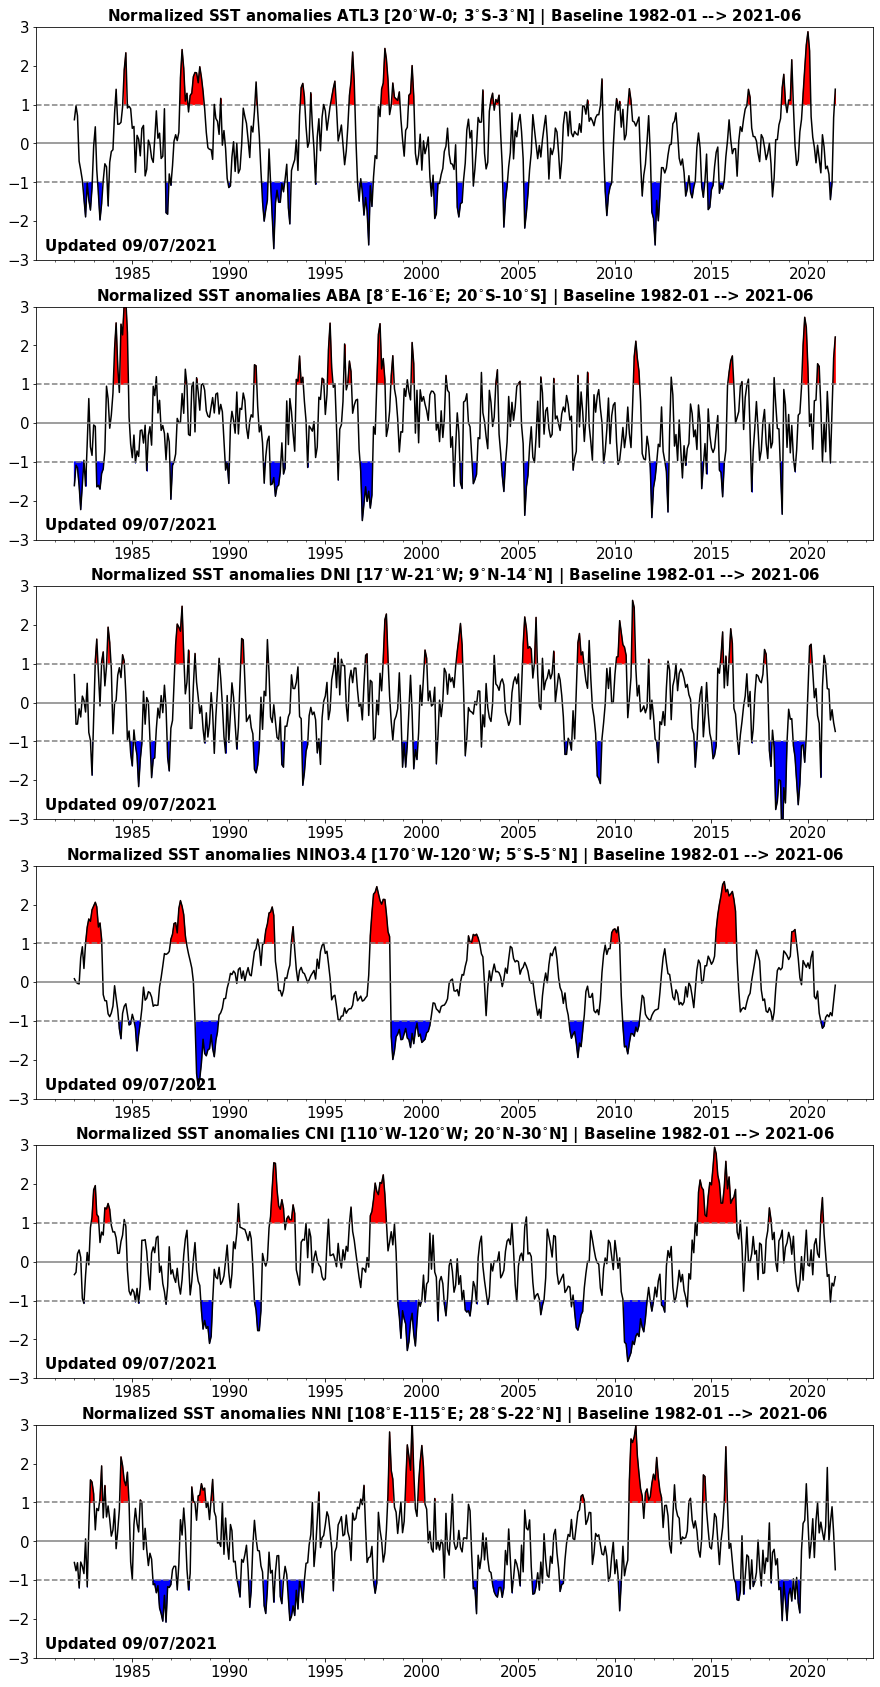

In [8]:
plot_anomalies(ssta_atl3_norm_cobe,
               ssta_aba_norm_cobe,
               ssta_nino34_norm_cobe,
               ssta_dni_norm_cobe,
               ssta_cni_norm_cobe,
               ssta_nni_norm_cobe)

# [OI SST v2](https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.html) | 1$^{\circ}$ x 1$^{\circ}$ | Monthly

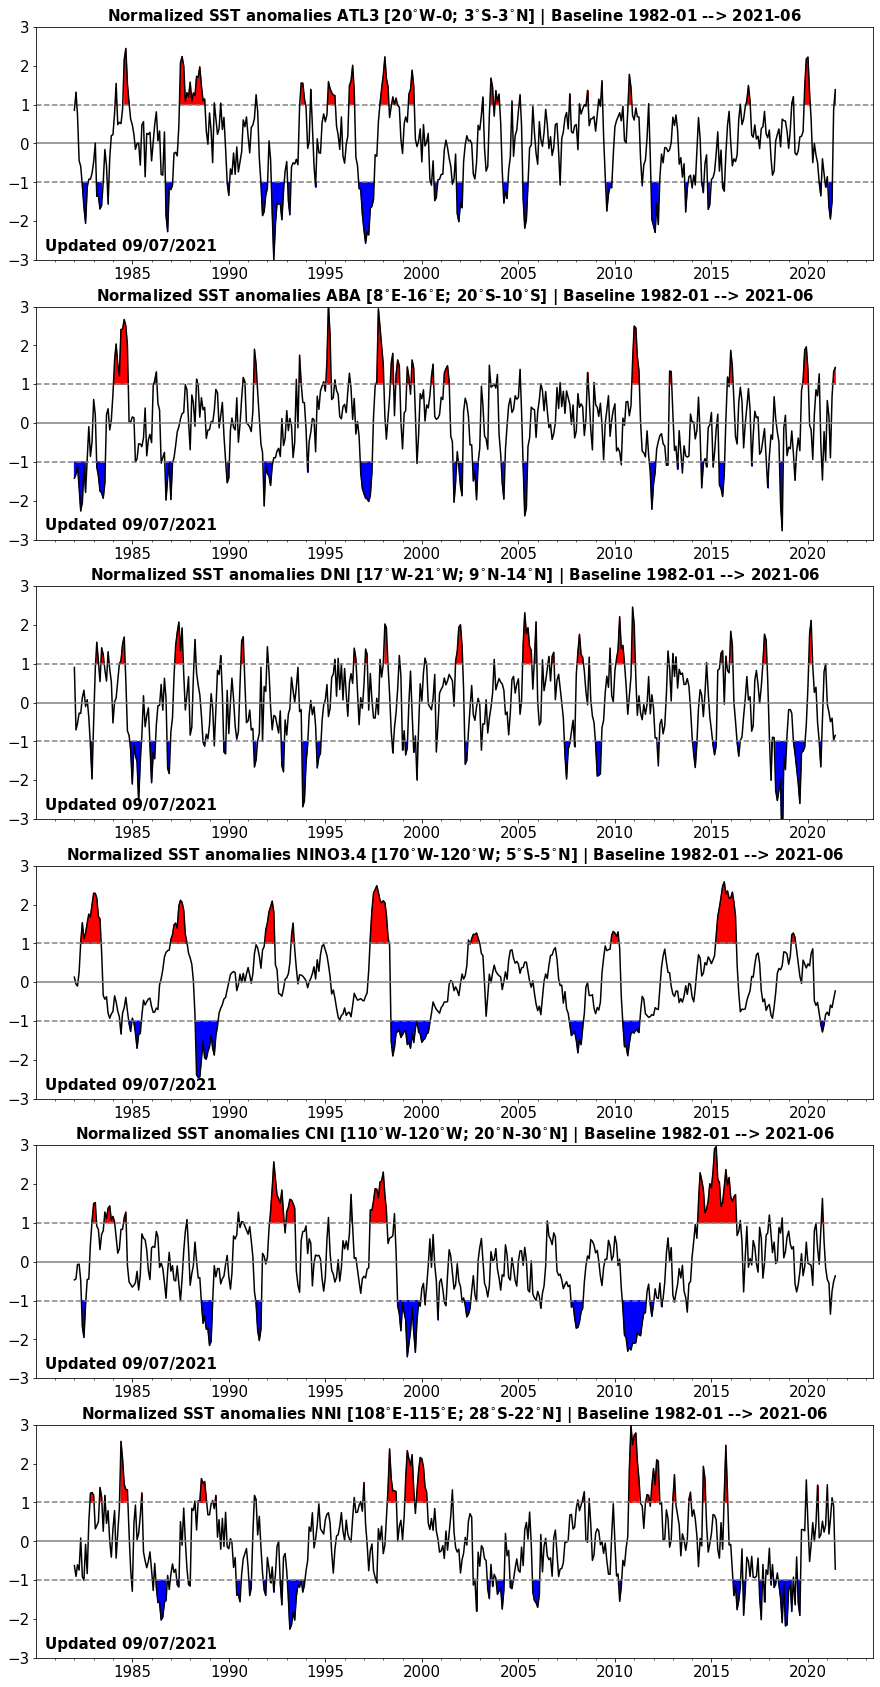

In [9]:
plot_anomalies(ssta_atl3_norm_oi,
               ssta_aba_norm_oi,
               ssta_nino34_norm_oi,
               ssta_dni_norm_oi,
               ssta_cni_norm_oi,
               ssta_nni_norm_oi)

# [ERSST V5](https://psl.noaa.gov/data/gridded/data.noaa.ersst.v5.html) | 2$^{\circ}$ x 2$^{\circ}$ | Monthly

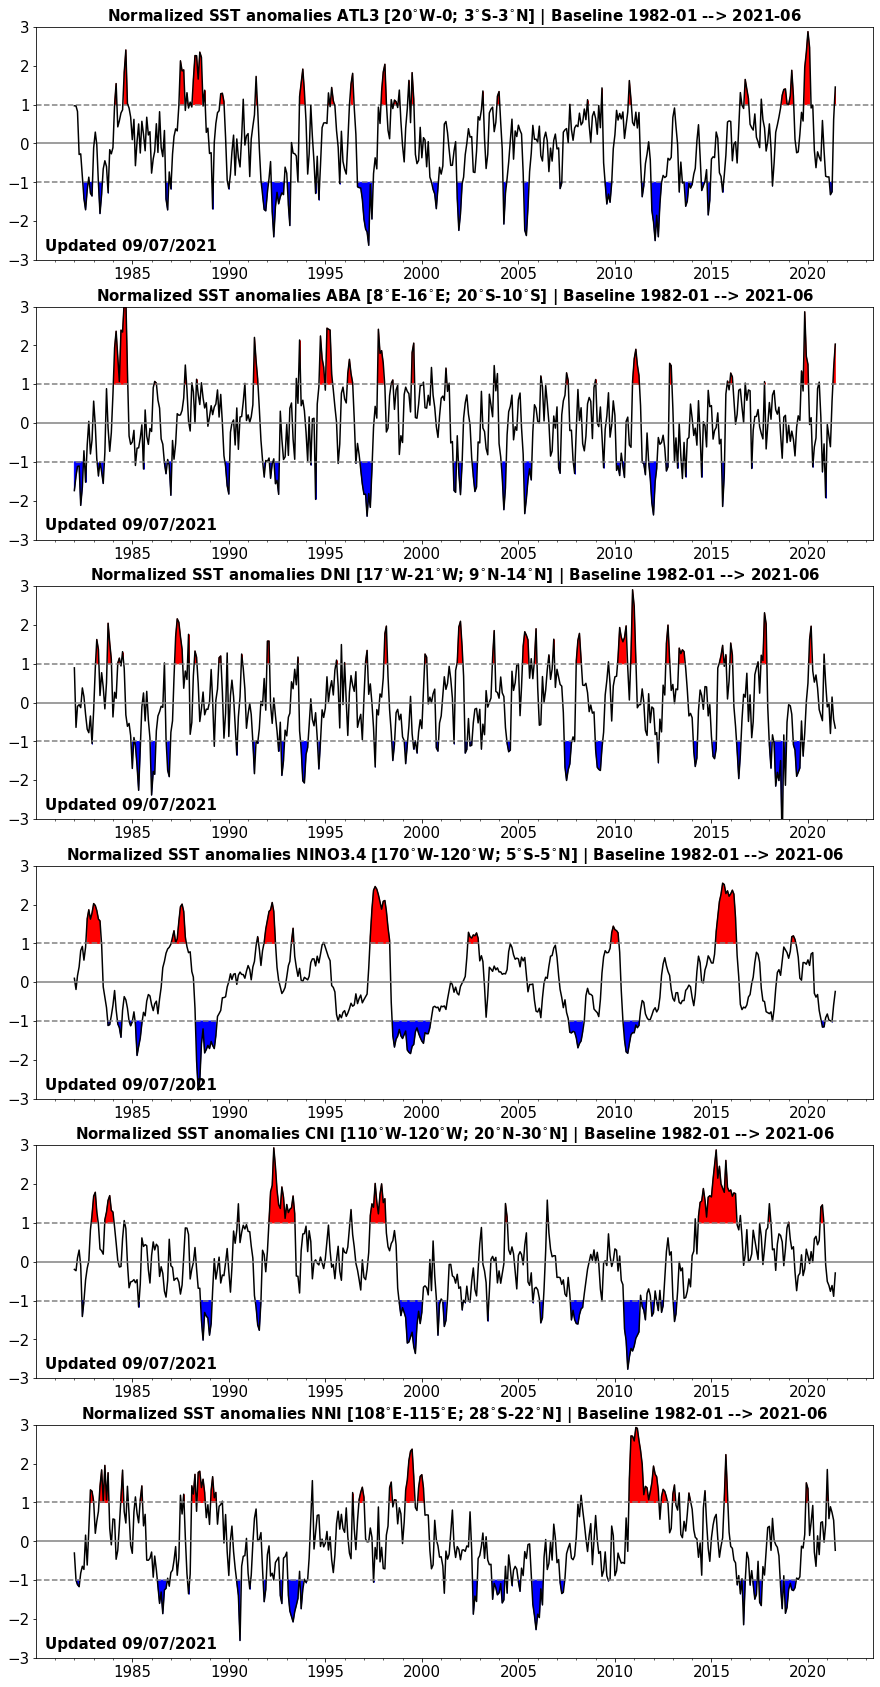

In [10]:
plot_anomalies(ssta_atl3_norm_ersst,
               ssta_aba_norm_ersst,
               ssta_nino34_norm_ersst,
               ssta_dni_norm_ersst,
               ssta_cni_norm_ersst,
               ssta_nni_norm_ersst)

# Weekly data

# [OI SST v2](https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.html) | 1$^{\circ}$ x 1$^{\circ}$ | Weekly |  <span style="color:red">ABA region only</span>.

<a id='ABA_weekly'></a>

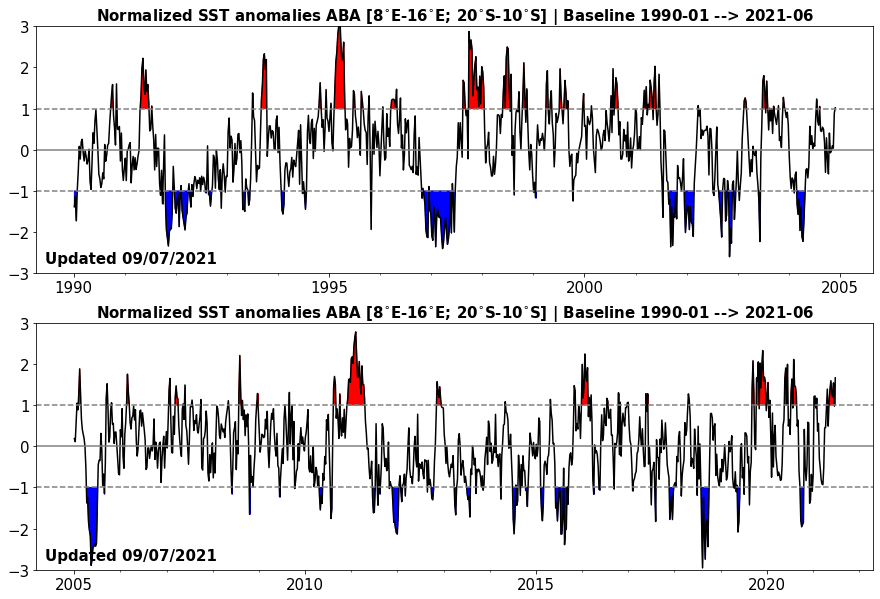

In [11]:
plot_anomalies_wk_aba(ssta_aba_norm_oi_wk)

# [OI SST v2](https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.html) | 1$^{\circ}$ x 1$^{\circ}$ | Weekly | <span style="color:blue">ATL3 region only</span>.
<a id='ATL3_weekly'></a>

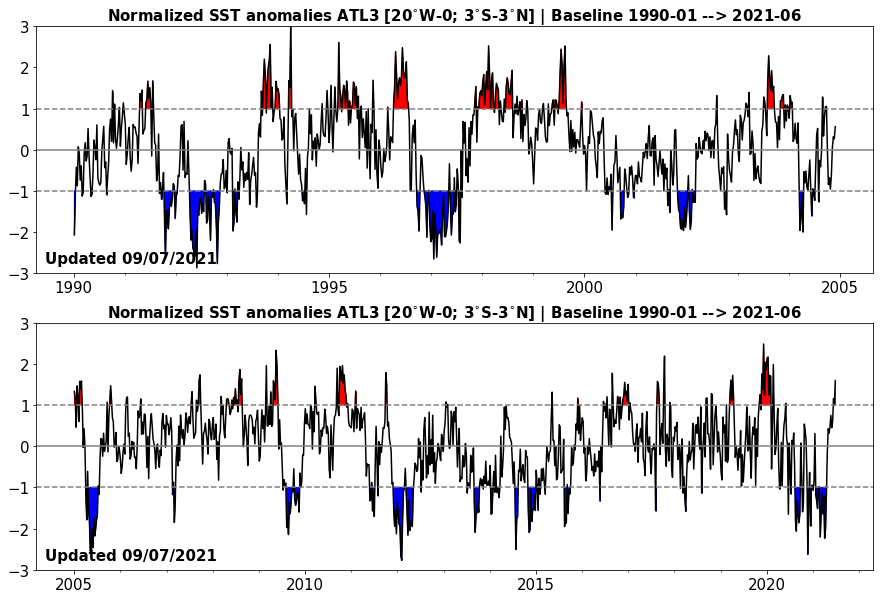

In [12]:
plot_anomalies_wk_atl3(ssta_atl3_norm_oi_wk)

# [OI SST v2](https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.html) | 1$^{\circ}$ x 1$^{\circ}$ | Weekly | <span style="color:green">NINO3.4 region only</span>.
<a id='NINO34_weekly'></a>

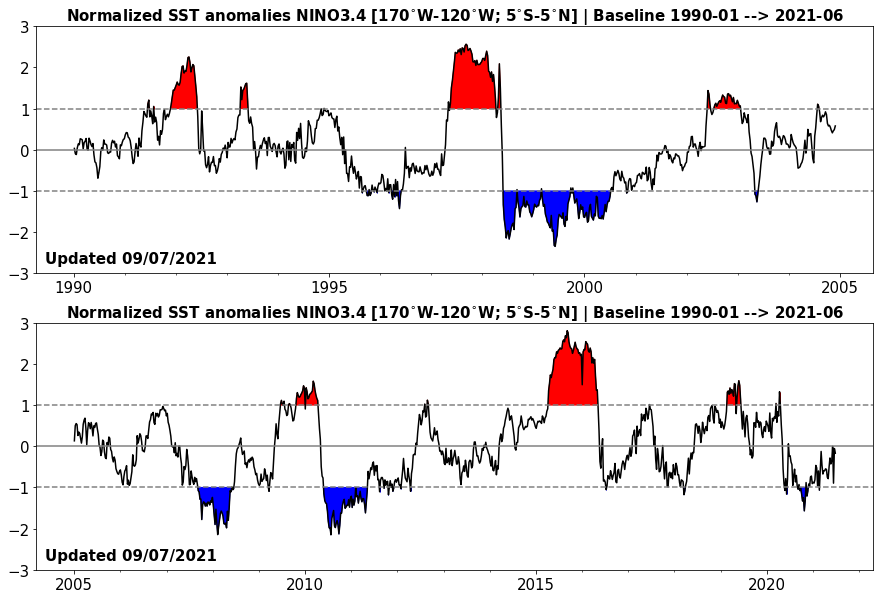

In [13]:
plot_anomalies_wk_nino34(ssta_nino34_norm_oi_wk)

# [OI SST v2](https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.html) | 1$^{\circ}$ x 1$^{\circ}$ | Weekly | <span style="color:orange">DNI region only</span>.
<a id='DNI_weekly'></a>

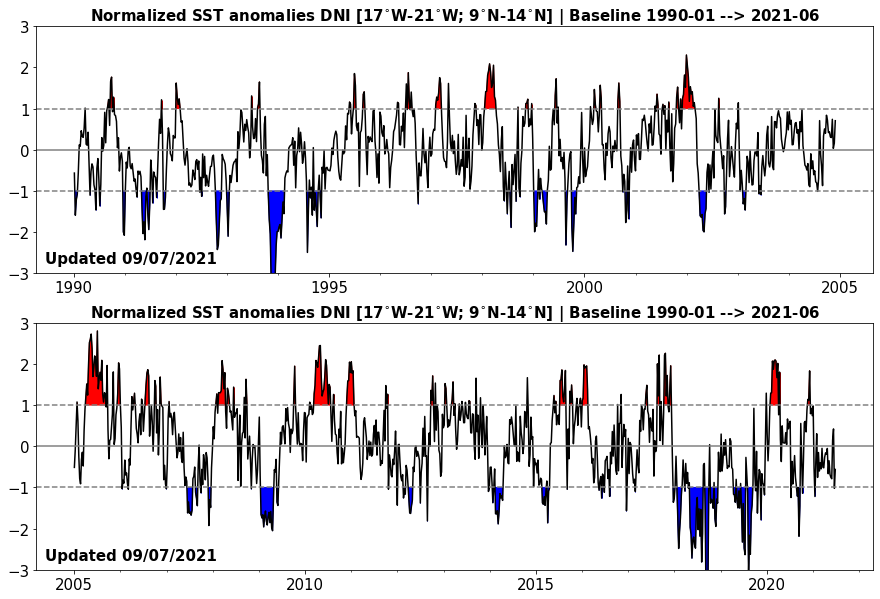

In [14]:
plot_anomalies_wk_dni(ssta_dni_norm_oi_wk)

# [OI SST v2](https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.html) | 1$^{\circ}$ x 1$^{\circ}$ | Weekly | <span style="color:pink">NNI region only</span>.
<a id='NNI_weekly'></a>

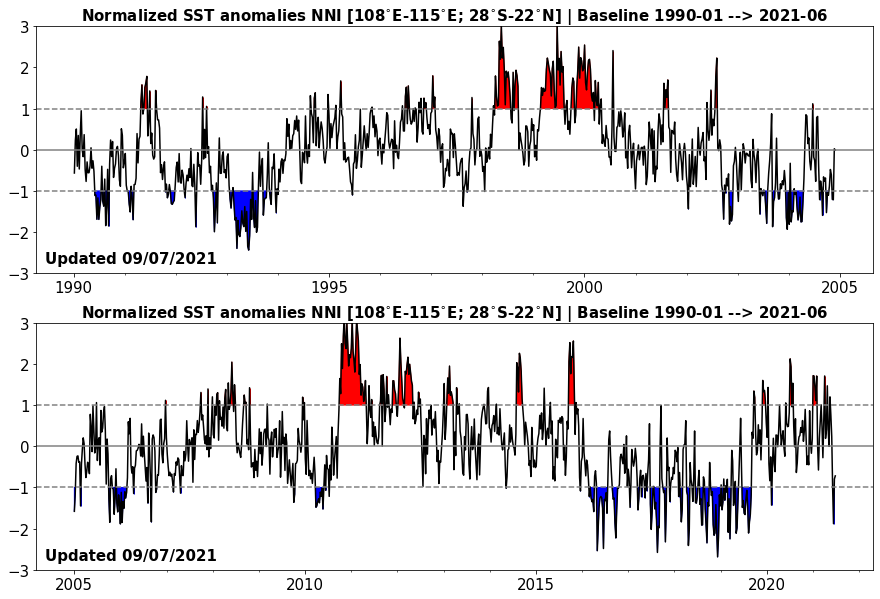

In [15]:
plot_anomalies_wk_nni(ssta_nni_norm_oi_wk)

# [OI SST v2](https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.html) | 1$^{\circ}$ x 1$^{\circ}$ | Weekly | <span style="color:grey">CNI region only</span>.
<a id='CNI_weekly'></a>

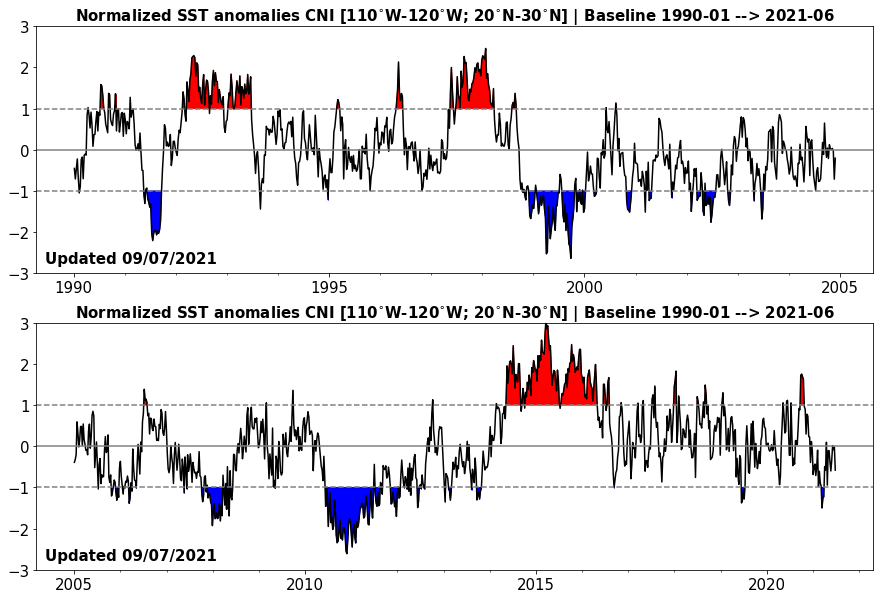

In [16]:
plot_anomalies_wk_cni(ssta_cni_norm_oi_wk)

# WAMOI: West African Monsoon onset index from 2000 to present day 
<a id='test'></a>

Methodology from : Fontaine, B., and S. Louvet (2006), Sudan-Sahel rainfall onset: Definition of an objective index, types of years, and
experimental hindcasts, J. Geophys. Res., 111, D20103, doi:10.1029/2005JD007019.


 # WAMOI = NI$_{std}$ - SI$_{std}$ 
 - with NI being the precipitation averaged over 7.5$^\circ$N-20$^\circ$N; 10$^\circ$W-10$^\circ$E
 - and with SI the precipitation averaged over 0$^\circ$N-7.5$^\circ$N; 10$^\circ$W-10$^\circ$E
 
 --> NI and SI are then standardized i.e. NI$_{std}$ = NI/(std(NI))
 
 
 !! to do apply a butterwoth time filter <15 days !!
 
 
### On the following plot, yearly WAMOI is plotted (grey lines), the mean of the WAMOI over the period 2000-2021 (black line) as well as the current year WAMOI(red line).

# [CPC Merged Analysis of Precipitation](https://psl.noaa.gov/data/gridded/data.cmap.html) | 2.5$^{\circ}$ x 2.5$^{\circ}$ | Weekly 

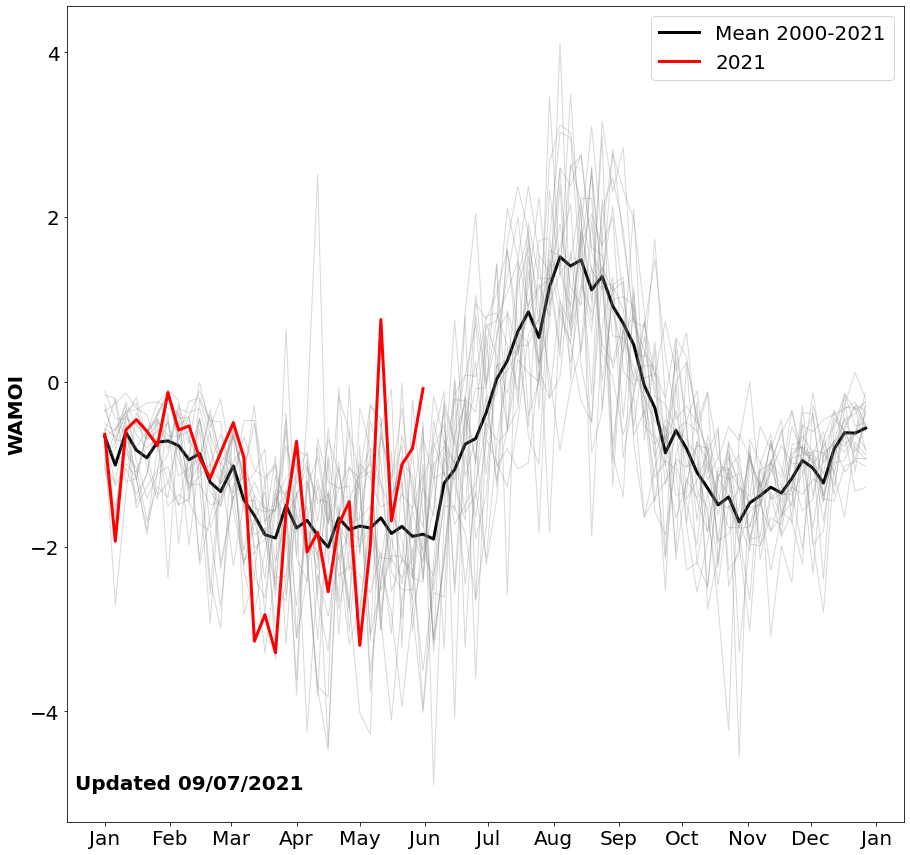

In [3]:
path_cmap = 'https://psl.noaa.gov/thredds/dodsC/Datasets/cmap/rt/precip.pentad.mean.rt.nc'
plot_wamoi(path_cmap)

# [Atlantic Meridional mode](https://www.aos.wisc.edu/~dvimont/MModes/AMM.html) | Chiang and Vimont (2004) | Monthly  <a id='test2'></a>

 The realtime AMM index is defined following the method of Chiang and Vimont (2004). The AMM spatial structure is defined via applying Maximum Covariance Analysis (MCA; Bretherton et al. 1992) is to tropical Atlantic SST and 10m winds over ocean regions between 75E and 15W, 21S to 32N. Data are obtained from the NCEP-NCAR Reanalysis (Kalnay et al. 1996), from NOAA ESRL. The spatial resolution is reduced by averaging three points in the zonal direction, and two points in the latitudinal direction, resulting in approximately 3.8deg latitude by 5.6deg longitude resolution over the region. Next, the seasonal cycle is removed, data are detrended, a three month running mean is applied to the data, and the equatorial Pacific Cold Tongue Index (SST averaged over 180-90W, 6S-6N) is removed (via linear regression) from all points. Finally, the data are weighted by the square root of the cosine of latitude, and the covariance matrix is formed between SST and winds (note the wind fields are appended to each other so the wind state vector has twice as many points as the SST state vector). The covariance matrix is decomposed via Singular Value Decomposition, and the leading statistical mode form the AMM SST and Wind patterns. The time period over which the patterns are computed is frozen as the 1950-2005 time period so that the patterns do not change as the index is being updated.

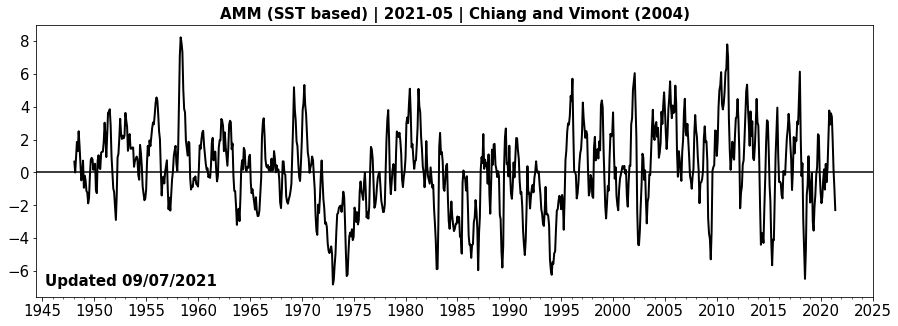

In [2]:
data_amm = 'https://www.aos.wisc.edu/~dvimont/MModes/RealTime/AMM.txt'
plot_amm(data_amm)